# Assignment 2

This assignment serves as a comprehensive evaluation of your machine learning skills, encompassing not only the technical aspects of model development but also your ability to analyze, interpret, and present data insights effectively. As such, it's essential to ensure that your submission is complete, functional, and devoid of any obvious gaps, as if you were delivering this project to a client.

To achieve this, leverage the full capabilities of Markdown and the interactive visualization tools available in Jupyter notebooks to craft a well-structured and visually appealing report of your findings. Your report should clearly communicate the insights you've gained from the exploratory data analysis, the rationale behind your data preprocessing and feature engineering decisions, and a thorough analysis of feature importance. High-quality visualizations and well-organized documentation will not only support your analysis but also make your results more accessible and understandable to your audience.

Remember, the ability to present complex results in an intuitive and engaging manner is a crucial skill, almost as important as the technical proficiency in model building and data analysis. Treat this assignment as an opportunity to showcase your skills in both areas.

## Instructions
- Your submission should be a `.ipynb` file with your name,
  like `FirstnameLastname.ipynb`. It should include the answers to the questions in markdown cells, your data analysis and results.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it by adding the source of the code as a comment in the first line of the code cell. [Academic misconduct policy](https://wiki.innopolis.university/display/DOE/Academic+misconduct+policy)
- In real life clients can give unclear goals or requirements. So, if the instructions seem vague, use common sense to make reasonable assumptions and decisions.

## Self-Reliance and Exploration
In this task, you're encouraged to rely on your resourcefulness and creativity. Dive into available resources, experiment with various solutions, and learn from every outcome. While our team is here to clarify task details and offer conceptual guidance, we encourage you to first seek answers independently. This approach is vital for developing your problem-solving skills in machine learning.



# Task 2: Image Classification with CNNs (50%)

In this task, you'll dive into the world of Convolutional Neural Networks (CNNs) by working with the CIFAR-10 dataset, a staple in image classification challenges. Your goal is to build and evaluate two different CNN models to classify images into one of the ten categories accurately.

The dataset is availabel in pytorch and keras.

## Part 1: Custom CNN Model (20%)

- Design and train a CNN model from scratch tailored for the CIFAR-10 dataset.
- Focus on the architecture that you believe will perform best for this specific task.
- Integrate various techniques such as batch normalization, dropout, learning rate schedulers, and early stopping to improve model training. Experiment with these methods and finetune them to see how they affect training stability, convergence speed, and overall performance.

## Part 2: Transfer Learning Model (20%)

- Implement a transfer learning approach using a pre-trained model of your choice.
- Fine-tune the model on the CIFAR-10 dataset to achieve the best possible performance.

## Evaluation (10%)

Ensure that both models are robust and generalized well to unseen data.

After training both models, you will evaluate them on a provided test dataset.

Compare your models based on:
- **AUC-ROC**: How well does each model discriminate between classes?
- **Model Size**: Consider the trade-offs in model complexity.
- **Inference Speed**: Evaluate how quickly your model can predict classes for new images.

Reflect on the performance, size, and inference speed of both models. What insights can you draw from these comparisons?

### Learning Objectives

- Understand and apply CNNs for image classification.
- Explore the impact of model architecture on performance and efficiency.
- Learn the process and benefits of transfer learning in deep learning.

Remember, the key to this task is not just about achieving the highest accuracy but also understanding the strengths and limitations of different approaches in machine learning model development.

## Part 1


To complete this task, I referenced the official [PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) and content covered in Lab10. I used Kaggle for training models.

CIFAR-10 is an image dataset that consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class.

![CIFAR-10 Example](https://pytorch.org/tutorials/_images/cifar10.png)

In [1]:
# Import nessesary libraries
import torch
import os
from torch.utils import data
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from time import time
from tqdm import tqdm
from torch.optim import SGD, Adam
from torch.optim import lr_scheduler

In [2]:
# Define transformations for training and test data
train_transforms_for_custom = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(12, shear=5, scale=(0.84, 1.14)),
    transforms.RandomRotation(18),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize the image with mean and standard deviation (as for pretrained model in next part)
])

test_transforms_for_custom = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalize the image with mean and standard deviation (as for pretrained model in next part)
])

In [3]:
batch_size = 128
# Load CIFAR-10 datasets for both training and testing
train_dataset_for_custom = datasets.CIFAR10(root='cifar10',
                                 train=True,
                                 transform=train_transforms_for_custom,
                                 download=True)

test_dataset_for_custom = datasets.CIFAR10(root='cifar10',
                                train=False,
                                transform=test_transforms_for_custom,
                                download=True)

# Create data loaders for training and testing datasets
train_data_loader_for_custom = data.DataLoader(train_dataset_for_custom,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=True)

test_data_loader_for_custom = data.DataLoader(test_dataset_for_custom,
                                   batch_size=batch_size,
                                   shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 46934502.65it/s]


Extracting cifar10/cifar-10-python.tar.gz to cifar10
Files already downloaded and verified


In [4]:
# Define device based on availability: CUDA, MPS, or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

cuda


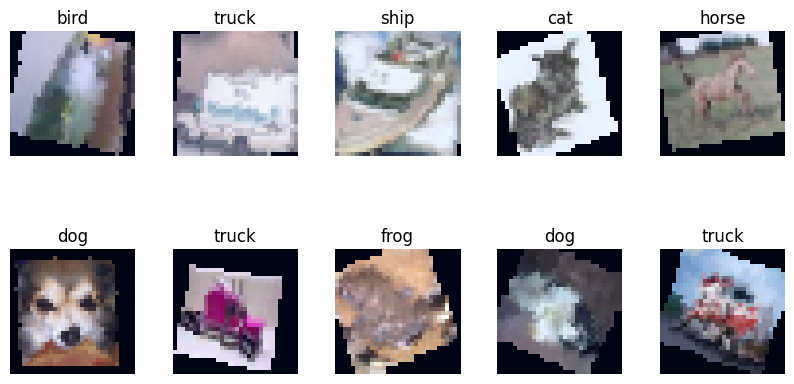

In [5]:
# Display 10 images with labels
def show_images(images, labels, classes, nrows=2, ncols=5, figsize=(10, 5)):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        image = images[i].permute(1, 2, 0)
        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image)
        ax.set_title(classes[labels[i]])
        ax.axis('off')
    plt.show()


classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dataiter = iter(train_data_loader_for_custom)
images, labels = next(dataiter)
show_images(images[:10], labels[:10], classes)

 Custom model for current task is an *updated version* of the model proposed in Lab10. The layer structure follows the proposed layout in Lab10:
**Conv → Activation → MaxPool → BatchNormalization or Dense → Activation → BatchNormalization → Dropout**


In [6]:
# Designing CNN model (Updated version of model from Lab10)
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout(p=0.1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=32),
            nn.Dropout(p=0.15)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.Dropout(p=0.2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=128),
            nn.Dropout(p=0.25)
        )

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=128 * 2 * 2, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=512),
            nn.Dropout(p=0.3)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=256),
            nn.Dropout(p=0.4)
        )
        self.fc3 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # Using log softmax activation for output probabilities as in Lab10
        return F.log_softmax(x, dim=1)

# Create an instance of the CustomModel and move it to the selected device
custom_model = CustomModel().to(device)
print(custom_model)

CustomModel(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.15, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.2, inplace=False)
 

In [7]:
# Class from https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py designed to implement early stopping functionality during training process
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [8]:
# Updated functions from Lab 10 used for train and test
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    epoch_loss = 0
    start_time = time()
    correct = 0
    total_samples = 0

    bar = tqdm(train_loader)
    for data, target in bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * data.size(0)
        total_samples += data.size(0)
        bar.set_postfix({"Loss": format(epoch_loss/total_samples, '.6f')})

    acc = 100. * correct / len(train_loader.dataset)
    epoch_loss = epoch_loss / total_samples
    print(f'\nTrain Epoch: {epoch}, elapsed time:{time()-start_time:.2f}s')
    return epoch_loss, acc


def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  * data.size(0)
            total_samples += data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100. * correct / len(test_loader.dataset)
    test_loss = test_loss / total_samples
    return test_loss, acc

In [9]:
# Updated function from Lab 10 used for training
def training(model, train_data_loader, test_data_loader, epochs, criterion, optimizer, scheduler, early_stopping, device, save_path):
    # Check if model already exists
    if save_path and os.path.exists(save_path):
        print(f"File already exists at {save_path}. Model not trained, loaded from file.")
        model_state_dict = torch.load(save_path, map_location=device)
        model.load_state_dict(model_state_dict)
        return

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(model, device, train_data_loader, criterion, optimizer, epoch)
        # Update learning rate if needed
        scheduler.step(train_loss)
        test_loss, test_acc = test(model, device, test_data_loader, criterion)
        # Terminate training if loss stopped to decrease
        if early_stopping(test_loss, model):
            print('\nEarly stopping\n')
            break
        print(f"Training accuracy {train_acc}, test accuracy {test_acc}")
        print(f"Training loss {train_loss}, test loss {test_loss}\n")

In [10]:
# Defining parameters for training
custom_model_path = "custom_model.pt"
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = SGD(custom_model.parameters(), lr=0.1, momentum=0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3, min_lr=0.001)
early_stopping = EarlyStopping(patience=5, delta=0.001, path=custom_model_path)

# Training model
training(custom_model, train_data_loader_for_custom, test_data_loader_for_custom, epochs, criterion, optimizer, scheduler, early_stopping, device, custom_model_path)

100%|██████████| 390/390 [00:36<00:00, 10.61it/s, Loss=1.973278]



Train Epoch: 1, elapsed time:36.75s
Training accuracy 32.106, test accuracy 45.16
Training loss 1.9732782614536775, test loss 1.4785219110488892



100%|██████████| 390/390 [00:35<00:00, 10.84it/s, Loss=1.505835]



Train Epoch: 2, elapsed time:35.98s
Training accuracy 44.526, test accuracy 52.21
Training loss 1.5058348487585018, test loss 1.3073134462356568



100%|██████████| 390/390 [00:36<00:00, 10.57it/s, Loss=1.399336]



Train Epoch: 3, elapsed time:36.91s
Training accuracy 48.984, test accuracy 58.05
Training loss 1.39933634354518, test loss 1.1668880536079407



100%|██████████| 390/390 [00:37<00:00, 10.47it/s, Loss=1.326718]



Train Epoch: 4, elapsed time:37.25s
EarlyStopping counter: 1 out of 5
Training accuracy 52.206, test accuracy 57.96
Training loss 1.3267176964344123, test loss 1.197142241859436



100%|██████████| 390/390 [00:36<00:00, 10.55it/s, Loss=1.277777]



Train Epoch: 5, elapsed time:36.98s
Training accuracy 54.216, test accuracy 64.33
Training loss 1.2777768654701038, test loss 1.0019659151077271



100%|██████████| 390/390 [00:36<00:00, 10.66it/s, Loss=1.237073]



Train Epoch: 6, elapsed time:36.59s
Training accuracy 55.808, test accuracy 64.27
Training loss 1.237072655176505, test loss 0.9932931248664856



100%|██████████| 390/390 [00:36<00:00, 10.56it/s, Loss=1.209738]



Train Epoch: 7, elapsed time:36.92s
Training accuracy 56.93, test accuracy 65.45
Training loss 1.2097379496464362, test loss 0.9700742327690125



100%|██████████| 390/390 [00:36<00:00, 10.58it/s, Loss=1.189276]



Train Epoch: 8, elapsed time:36.87s
Training accuracy 57.686, test accuracy 67.22
Training loss 1.1892758190631867, test loss 0.9381240077972413



100%|██████████| 390/390 [00:35<00:00, 10.86it/s, Loss=1.167425]



Train Epoch: 9, elapsed time:35.90s
Training accuracy 58.724, test accuracy 68.18
Training loss 1.1674254626799851, test loss 0.901667908859253



100%|██████████| 390/390 [00:34<00:00, 11.19it/s, Loss=1.147706]



Train Epoch: 10, elapsed time:34.85s
EarlyStopping counter: 1 out of 5
Training accuracy 59.22, test accuracy 67.35
Training loss 1.1477063522889064, test loss 0.911603758239746



100%|██████████| 390/390 [00:34<00:00, 11.39it/s, Loss=1.131957]



Train Epoch: 11, elapsed time:34.25s
Training accuracy 59.954, test accuracy 69.7
Training loss 1.131957146143302, test loss 0.8550592754364014



100%|██████████| 390/390 [00:34<00:00, 11.32it/s, Loss=1.118194]



Train Epoch: 12, elapsed time:34.44s
EarlyStopping counter: 1 out of 5
Training accuracy 60.434, test accuracy 69.49
Training loss 1.1181941891327882, test loss 0.8604825777053833



100%|██████████| 390/390 [00:34<00:00, 11.18it/s, Loss=1.099650]



Train Epoch: 13, elapsed time:34.90s
Training accuracy 61.166, test accuracy 70.95
Training loss 1.0996502737204235, test loss 0.8241155791282654



100%|██████████| 390/390 [00:34<00:00, 11.22it/s, Loss=1.091065]



Train Epoch: 14, elapsed time:34.76s
Training accuracy 61.256, test accuracy 71.77
Training loss 1.0910652400591434, test loss 0.8059086391448974



100%|██████████| 390/390 [00:34<00:00, 11.33it/s, Loss=1.075542]



Train Epoch: 15, elapsed time:34.44s
EarlyStopping counter: 1 out of 5
Training accuracy 62.122, test accuracy 70.69
Training loss 1.075541523633859, test loss 0.8200918906211853



100%|██████████| 390/390 [00:34<00:00, 11.37it/s, Loss=1.066104]



Train Epoch: 16, elapsed time:34.29s
Training accuracy 62.386, test accuracy 71.71
Training loss 1.0661037324330747, test loss 0.7958746930122376



100%|██████████| 390/390 [00:34<00:00, 11.36it/s, Loss=1.055765]



Train Epoch: 17, elapsed time:34.32s
EarlyStopping counter: 1 out of 5
Training accuracy 62.74, test accuracy 70.64
Training loss 1.0557650190133314, test loss 0.8171941089630127



100%|██████████| 390/390 [00:34<00:00, 11.28it/s, Loss=1.044425]



Train Epoch: 18, elapsed time:34.57s
Training accuracy 63.168, test accuracy 72.24
Training loss 1.0444253382010338, test loss 0.7885958081245422



100%|██████████| 390/390 [00:34<00:00, 11.19it/s, Loss=1.036000]



Train Epoch: 19, elapsed time:34.86s
Training accuracy 63.442, test accuracy 73.23
Training loss 1.0360001736726516, test loss 0.7596048027038574



100%|██████████| 390/390 [00:34<00:00, 11.22it/s, Loss=1.032516]



Train Epoch: 20, elapsed time:34.76s
EarlyStopping counter: 1 out of 5
Training accuracy 63.686, test accuracy 72.22
Training loss 1.0325164414369143, test loss 0.7809243935585022



100%|██████████| 390/390 [00:34<00:00, 11.28it/s, Loss=1.027015]



Train Epoch: 21, elapsed time:34.58s
Training accuracy 63.692, test accuracy 73.38
Training loss 1.027015180618335, test loss 0.7549391597747803



100%|██████████| 390/390 [00:34<00:00, 11.36it/s, Loss=1.016618]



Train Epoch: 22, elapsed time:34.34s
Training accuracy 64.154, test accuracy 73.55
Training loss 1.0166184853284788, test loss 0.7531828640937805



100%|██████████| 390/390 [00:34<00:00, 11.22it/s, Loss=1.011647]



Train Epoch: 23, elapsed time:34.76s
Training accuracy 64.492, test accuracy 74.25
Training loss 1.011646786561379, test loss 0.7321012458801269



100%|██████████| 390/390 [00:34<00:00, 11.31it/s, Loss=1.005379]



Train Epoch: 24, elapsed time:34.50s
EarlyStopping counter: 1 out of 5
Training accuracy 64.45, test accuracy 73.54
Training loss 1.0053790246829009, test loss 0.7416124922752381



100%|██████████| 390/390 [00:34<00:00, 11.32it/s, Loss=0.991348]



Train Epoch: 25, elapsed time:34.45s
EarlyStopping counter: 2 out of 5
Training accuracy 64.992, test accuracy 72.78
Training loss 0.9913483038926736, test loss 0.7790105856895447



100%|██████████| 390/390 [00:34<00:00, 11.26it/s, Loss=0.994047]



Train Epoch: 26, elapsed time:34.64s
Training accuracy 65.186, test accuracy 74.49
Training loss 0.9940465149206993, test loss 0.7144691747665405



100%|██████████| 390/390 [00:35<00:00, 11.09it/s, Loss=0.983977]



Train Epoch: 27, elapsed time:35.18s
EarlyStopping counter: 1 out of 5
Training accuracy 65.316, test accuracy 74.59
Training loss 0.9839773054306323, test loss 0.7173128128051758



100%|██████████| 390/390 [00:35<00:00, 11.14it/s, Loss=0.980362]



Train Epoch: 28, elapsed time:35.03s
Training accuracy 65.662, test accuracy 75.16
Training loss 0.9803618009273822, test loss 0.7086989820480347



100%|██████████| 390/390 [00:35<00:00, 11.12it/s, Loss=0.977831]



Train Epoch: 29, elapsed time:35.07s
EarlyStopping counter: 1 out of 5
Training accuracy 65.548, test accuracy 73.8
Training loss 0.9778312757993356, test loss 0.7227455888748169



100%|██████████| 390/390 [00:34<00:00, 11.14it/s, Loss=0.972180]



Train Epoch: 30, elapsed time:35.00s
EarlyStopping counter: 2 out of 5
Training accuracy 65.864, test accuracy 73.57
Training loss 0.972180340381769, test loss 0.7354576494693756



100%|██████████| 390/390 [00:34<00:00, 11.18it/s, Loss=0.970412]



Train Epoch: 31, elapsed time:34.90s
Training accuracy 65.988, test accuracy 75.13
Training loss 0.970412432994598, test loss 0.7045288317680359



100%|██████████| 390/390 [00:34<00:00, 11.21it/s, Loss=0.965792]



Train Epoch: 32, elapsed time:34.80s
EarlyStopping counter: 1 out of 5
Training accuracy 65.976, test accuracy 75.48
Training loss 0.9657922915923289, test loss 0.7113640734672546



100%|██████████| 390/390 [00:34<00:00, 11.25it/s, Loss=0.958579]



Train Epoch: 33, elapsed time:34.66s
Training accuracy 66.112, test accuracy 75.11
Training loss 0.958579224959398, test loss 0.6979238953590393



100%|██████████| 390/390 [00:34<00:00, 11.32it/s, Loss=0.954262]



Train Epoch: 34, elapsed time:34.47s
Training accuracy 66.546, test accuracy 76.48
Training loss 0.9542619239061306, test loss 0.6662173608779908



100%|██████████| 390/390 [00:34<00:00, 11.25it/s, Loss=0.956813]



Train Epoch: 35, elapsed time:34.68s
EarlyStopping counter: 1 out of 5
Training accuracy 66.334, test accuracy 75.07
Training loss 0.9568129192560147, test loss 0.7036393304347992



100%|██████████| 390/390 [00:34<00:00, 11.24it/s, Loss=0.943072]



Train Epoch: 36, elapsed time:34.69s
EarlyStopping counter: 2 out of 5
Training accuracy 66.932, test accuracy 75.75
Training loss 0.9430723760372554, test loss 0.6838536403179168



100%|██████████| 390/390 [00:34<00:00, 11.23it/s, Loss=0.945754]



Train Epoch: 37, elapsed time:34.73s
EarlyStopping counter: 3 out of 5
Training accuracy 66.48, test accuracy 76.49
Training loss 0.9457535826242887, test loss 0.6666791082859039



100%|██████████| 390/390 [00:34<00:00, 11.17it/s, Loss=0.945991]



Train Epoch: 38, elapsed time:34.91s
Training accuracy 66.766, test accuracy 76.86
Training loss 0.945990762190941, test loss 0.6588189487934113



100%|██████████| 390/390 [00:34<00:00, 11.23it/s, Loss=0.935972]



Train Epoch: 39, elapsed time:34.74s
EarlyStopping counter: 1 out of 5
Training accuracy 67.156, test accuracy 76.74
Training loss 0.9359718790421119, test loss 0.6643675252437592



100%|██████████| 390/390 [00:34<00:00, 11.26it/s, Loss=0.932418]



Train Epoch: 40, elapsed time:34.65s
Training accuracy 67.254, test accuracy 77.13
Training loss 0.9324179400236179, test loss 0.6503111779212951



100%|██████████| 390/390 [00:34<00:00, 11.22it/s, Loss=0.936485]



Train Epoch: 41, elapsed time:34.76s
EarlyStopping counter: 1 out of 5
Training accuracy 67.156, test accuracy 76.35
Training loss 0.9364845868868705, test loss 0.669560715675354



100%|██████████| 390/390 [00:34<00:00, 11.16it/s, Loss=0.926605]



Train Epoch: 42, elapsed time:34.96s
Training accuracy 67.564, test accuracy 77.04
Training loss 0.9266050668863149, test loss 0.6492212767601013



100%|██████████| 390/390 [00:34<00:00, 11.22it/s, Loss=0.927690]



Train Epoch: 43, elapsed time:34.77s
Training accuracy 67.32, test accuracy 77.52
Training loss 0.927689571869679, test loss 0.6433945807933807



100%|██████████| 390/390 [00:34<00:00, 11.20it/s, Loss=0.917627]



Train Epoch: 44, elapsed time:34.82s
EarlyStopping counter: 1 out of 5
Training accuracy 67.436, test accuracy 76.51
Training loss 0.9176267607089801, test loss 0.6615228910923004



100%|██████████| 390/390 [00:34<00:00, 11.27it/s, Loss=0.921545]



Train Epoch: 45, elapsed time:34.60s
EarlyStopping counter: 2 out of 5
Training accuracy 67.442, test accuracy 76.69
Training loss 0.921544631322225, test loss 0.6721334679603577



100%|██████████| 390/390 [00:34<00:00, 11.30it/s, Loss=0.915540]



Train Epoch: 46, elapsed time:34.52s
Training accuracy 67.9, test accuracy 78.08
Training loss 0.9155399684722607, test loss 0.635228082370758



100%|██████████| 390/390 [00:35<00:00, 11.08it/s, Loss=0.918325]



Train Epoch: 47, elapsed time:35.19s
EarlyStopping counter: 1 out of 5
Training accuracy 67.85, test accuracy 77.42
Training loss 0.9183250219393999, test loss 0.6433691531181336



100%|██████████| 390/390 [00:34<00:00, 11.20it/s, Loss=0.915857]



Train Epoch: 48, elapsed time:34.82s
EarlyStopping counter: 2 out of 5
Training accuracy 67.848, test accuracy 76.82
Training loss 0.9158571868370741, test loss 0.6583270173072815



100%|██████████| 390/390 [00:34<00:00, 11.41it/s, Loss=0.913349]



Train Epoch: 49, elapsed time:34.17s
EarlyStopping counter: 3 out of 5
Training accuracy 67.962, test accuracy 76.36
Training loss 0.9133494647649618, test loss 0.6772525729656219



100%|██████████| 390/390 [00:34<00:00, 11.45it/s, Loss=0.907449]



Train Epoch: 50, elapsed time:34.06s
EarlyStopping counter: 4 out of 5
Training accuracy 68.488, test accuracy 76.75
Training loss 0.9074485780336918, test loss 0.6496751041412353



100%|██████████| 390/390 [00:34<00:00, 11.42it/s, Loss=0.904746]



Train Epoch: 51, elapsed time:34.14s
Training accuracy 68.172, test accuracy 78.59
Training loss 0.904745780199002, test loss 0.6143406036376953



100%|██████████| 390/390 [00:34<00:00, 11.34it/s, Loss=0.904555]



Train Epoch: 52, elapsed time:34.39s
EarlyStopping counter: 1 out of 5
Training accuracy 68.29, test accuracy 78.45
Training loss 0.904554559634282, test loss 0.6282441094875336



100%|██████████| 390/390 [00:34<00:00, 11.42it/s, Loss=0.902421]



Train Epoch: 53, elapsed time:34.17s
Training accuracy 68.426, test accuracy 78.47
Training loss 0.9024207032643832, test loss 0.612706809425354



100%|██████████| 390/390 [00:34<00:00, 11.43it/s, Loss=0.899909]



Train Epoch: 54, elapsed time:34.13s
EarlyStopping counter: 1 out of 5
Training accuracy 68.348, test accuracy 78.26
Training loss 0.8999087900687487, test loss 0.6224197965621948



100%|██████████| 390/390 [00:33<00:00, 11.55it/s, Loss=0.899191]



Train Epoch: 55, elapsed time:33.76s
EarlyStopping counter: 2 out of 5
Training accuracy 68.438, test accuracy 78.28
Training loss 0.8991907231318645, test loss 0.6203622197151184



100%|██████████| 390/390 [00:33<00:00, 11.51it/s, Loss=0.895483]



Train Epoch: 56, elapsed time:33.90s
EarlyStopping counter: 3 out of 5
Training accuracy 68.43, test accuracy 77.96
Training loss 0.8954829781483381, test loss 0.6191749928474426



100%|██████████| 390/390 [00:34<00:00, 11.41it/s, Loss=0.895490]



Train Epoch: 57, elapsed time:34.17s
EarlyStopping counter: 4 out of 5
Training accuracy 68.66, test accuracy 78.02
Training loss 0.8954899048193907, test loss 0.6206120646476746



100%|██████████| 390/390 [00:34<00:00, 11.44it/s, Loss=0.897677]



Train Epoch: 58, elapsed time:34.08s
EarlyStopping counter: 5 out of 5

Early stopping



## Part 2


In [11]:
# Import nessesary libraries
from torchvision.models import resnet50, ResNet50_Weights

In [12]:
# Define transformations for training and test data
train_transforms_for_pretrained = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=4, scale=(0.9, 1.1)),
    transforms.RandomRotation(15),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Values taken from https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
])

test_transforms_for_pretrained = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Values taken from https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
])


In [13]:
batch_size = 128

# Load CIFAR-10 datasets for both training and testing
train_dataset_for_pretrained = datasets.CIFAR10(root='cifar10',
                                 train=True,
                                 transform=train_transforms_for_pretrained,
                                 download=True)

test_dataset_for_pretrained = datasets.CIFAR10(root='cifar10',
                                train=False,
                                transform=test_transforms_for_pretrained,
                                download=True)

# Create data loaders for training and testing datasets
train_data_loader_for_pretrained = data.DataLoader(train_dataset_for_pretrained,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=True)

test_data_loader_for_pretrained = data.DataLoader(test_dataset_for_pretrained,
                                   batch_size=batch_size,
                                   shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


A model from the **PyTorch Vision library presented in the official documentation** ([PyTorch](https://pytorch.org/vision/stable/models.html)) was chosen.

In [14]:
# Load the pre-trained ResNet-50 model with pre-trained weights
weights = ResNet50_Weights.IMAGENET1K_V2
pretrained_model = resnet50(weights=weights)

# Replace the fully connected layer with a new one that has 10 output classes
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, 10)
pretrained_model = pretrained_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


In [15]:
# Defining parameters for training
epochs = 50
pretrained_model_path = "pretrained_model.pt"
criterion = nn.CrossEntropyLoss()
optimizer = SGD(pretrained_model.parameters(), lr=0.1, momentum=0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=2, min_lr=0.001)
early_stopping = EarlyStopping(patience=3, delta=0.001, path=pretrained_model_path, verbose=True)

In [16]:
# Training modidied pretrained_model
training(pretrained_model, train_data_loader_for_pretrained, test_data_loader_for_pretrained, epochs, criterion, optimizer, scheduler, early_stopping, device, save_path=pretrained_model_path)

100%|██████████| 390/390 [09:48<00:00,  1.51s/it, Loss=0.661055]



Train Epoch: 1, elapsed time:588.29s
Validation loss decreased (inf --> 0.453509).  Saving model ...
Training accuracy 76.948, test accuracy 85.19
Training loss 0.6610549161831538, test loss 0.45350863065719604



100%|██████████| 390/390 [09:49<00:00,  1.51s/it, Loss=0.370844]



Train Epoch: 2, elapsed time:589.13s
Validation loss decreased (0.453509 --> 0.276489).  Saving model ...
Training accuracy 86.882, test accuracy 90.54
Training loss 0.3708444599157725, test loss 0.2764887520313263



100%|██████████| 390/390 [09:48<00:00,  1.51s/it, Loss=0.290236]



Train Epoch: 3, elapsed time:588.82s
Validation loss decreased (0.276489 --> 0.235781).  Saving model ...
Training accuracy 89.722, test accuracy 92.02
Training loss 0.29023628169909504, test loss 0.2357808901309967



100%|██████████| 390/390 [09:49<00:00,  1.51s/it, Loss=0.237675]



Train Epoch: 4, elapsed time:589.41s
Validation loss decreased (0.235781 --> 0.234340).  Saving model ...
Training accuracy 91.484, test accuracy 92.54
Training loss 0.2376748816516155, test loss 0.23433982133865355



100%|██████████| 390/390 [09:49<00:00,  1.51s/it, Loss=0.206475]



Train Epoch: 5, elapsed time:589.51s
EarlyStopping counter: 1 out of 3
Training accuracy 92.746, test accuracy 92.05
Training loss 0.20647475537963403, test loss 0.24862312312722207



100%|██████████| 390/390 [09:47<00:00,  1.51s/it, Loss=0.176767]



Train Epoch: 6, elapsed time:587.99s
Validation loss decreased (0.234340 --> 0.202544).  Saving model ...
Training accuracy 93.648, test accuracy 93.72
Training loss 0.1767667441509473, test loss 0.20254365866184235



100%|██████████| 390/390 [09:48<00:00,  1.51s/it, Loss=0.156547]



Train Epoch: 7, elapsed time:588.50s
EarlyStopping counter: 1 out of 3
Training accuracy 94.458, test accuracy 90.86
Training loss 0.15654659228256115, test loss 0.3095897892475128



100%|██████████| 390/390 [09:48<00:00,  1.51s/it, Loss=0.137321]



Train Epoch: 8, elapsed time:588.81s
EarlyStopping counter: 2 out of 3
Training accuracy 95.0, test accuracy 93.8
Training loss 0.13732055159142384, test loss 0.20281679849624634



100%|██████████| 390/390 [09:48<00:00,  1.51s/it, Loss=0.128349]



Train Epoch: 9, elapsed time:588.55s
Validation loss decreased (0.202544 --> 0.187852).  Saving model ...
Training accuracy 95.298, test accuracy 94.2
Training loss 0.12834867945848366, test loss 0.18785181107521057



100%|██████████| 390/390 [09:48<00:00,  1.51s/it, Loss=0.112715]



Train Epoch: 10, elapsed time:588.04s
EarlyStopping counter: 1 out of 3
Training accuracy 95.926, test accuracy 94.18
Training loss 0.11271495073078534, test loss 0.19509586753845215



100%|██████████| 390/390 [09:48<00:00,  1.51s/it, Loss=0.103935]



Train Epoch: 11, elapsed time:588.54s
EarlyStopping counter: 2 out of 3
Training accuracy 96.042, test accuracy 93.65
Training loss 0.10393539526237128, test loss 0.2225963897705078



100%|██████████| 390/390 [09:47<00:00,  1.51s/it, Loss=0.097109]



Train Epoch: 12, elapsed time:587.36s
Validation loss decreased (0.187852 --> 0.182080).  Saving model ...
Training accuracy 96.514, test accuracy 94.65
Training loss 0.09710901462687896, test loss 0.18207985880374908



100%|██████████| 390/390 [09:48<00:00,  1.51s/it, Loss=0.086364]



Train Epoch: 13, elapsed time:588.61s
EarlyStopping counter: 1 out of 3
Training accuracy 96.822, test accuracy 94.46
Training loss 0.08636444801321397, test loss 0.18708645663261414



100%|██████████| 390/390 [09:48<00:00,  1.51s/it, Loss=0.080375]



Train Epoch: 14, elapsed time:588.98s
EarlyStopping counter: 2 out of 3
Training accuracy 97.084, test accuracy 94.19
Training loss 0.0803753073924245, test loss 0.20306019854545593



100%|██████████| 390/390 [09:47<00:00,  1.51s/it, Loss=0.070490]



Train Epoch: 15, elapsed time:587.74s
EarlyStopping counter: 3 out of 3

Early stopping



## Evaluation

In [17]:
# Import nessesary libraries
from torch.utils.data import Dataset
from PIL import Image
from sklearn.metrics import accuracy_score, roc_auc_score
import time

In [18]:
# Creating custom dataset ad loaders as here https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

batch_size = 128
test_images_path = '/kaggle/input/task-2/task_2_test_images.npy'
test_labels_path = '/kaggle/input/task-2/task_2_test_labels.npy'

np_images = np.load(test_images_path)
np_labels = np.load(test_labels_path)

test_dataset_for_custom = CustomDataset(np_images, np_labels, test_transforms_for_custom)
test_dataset_for_pretrained = CustomDataset(np_images, np_labels, test_transforms_for_pretrained)

test_loader_for_custom = torch.utils.data.DataLoader(test_dataset_for_custom, batch_size=batch_size, shuffle=False)
test_loader_for_pretrained = torch.utils.data.DataLoader(test_dataset_for_pretrained, batch_size=batch_size, shuffle=False)

In [19]:
# Fucntions to calculate metrics
def get_model_size(model):
    total_params = sum([param.numel() for param in model.parameters()])
    return total_params

def evaluate_model(model, data_loader):
    model.eval()
    device = next(model.parameters()).device

    true_labels = []
    predicted_labels = []
    predicted_probs = []
    start_time = time.time()
    total_time = 0
    len_images = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            len_images += images.size(0)

            start_time = time.time()
            outputs = model(images)
            total_time += time.time() - start_time

            probabilities = torch.nn.functional.softmax(outputs, dim=-1)
            _, predictions = torch.max(probabilities, dim=1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predictions.cpu().numpy())
            predicted_probs.extend(probabilities.cpu().numpy())

    inference_time = total_time * 1000 / len_images

    accuracy = accuracy_score(true_labels, predicted_labels)
    auc = roc_auc_score(true_labels, predicted_probs, multi_class="ovr")
    model_size = get_model_size(model)

    result_dict = {
        "Accuracy": accuracy,
        "ROC-AUC": auc,
        "Inference_speed": inference_time,
        "Model_size": model_size
    }

    return result_dict

In [20]:
print(evaluate_model(custom_model, test_loader_for_custom))
print(evaluate_model(pretrained_model, test_loader_for_pretrained))

{'Accuracy': 0.6567898754519887, 'ROC-AUC': 0.9440565784907422, 'Inference_speed': 0.012834850876816978, 'Model_size': 496010}
{'Accuracy': 0.7646645239051828, 'ROC-AUC': 0.9666107088644926, 'Inference_speed': 0.06685873838541928, 'Model_size': 23528522}


### Performance (Accuracy and ROC-AUC)
With a ROC-AUC score of 94.40% and a decent accuracy of around 65.67%, the custom model performs well. But with greater accuracy (76.46%) and ROC-AUC (96.66%), the transfer learning model performs better than it.

### Model size
The transfer learning model has 23,528,522 parameters, but the custom model has just 496,010 parameters. This is a substantial difference.

### Inference speed
The custom model processes a picture in around 0.0128 ms, demonstrating very good inference speed. By comparison, the inference speed of the transfer learning model is 0.0668 ms per picture, which is a notable slowdown.

### Insights
In terms of accuracy and ROC-AUC score, the transfer learning model performs better overall than the custom model.  Though the transfer learning model takes around 6 times longer to create predictions than the custom model, also its higher performance comes at a cost of much slower inference speed. Furthermore, the transfer learning model is almost 47 times bigger than the custom model, indicating a significant difference in model size. Because of this, even while the transfer learning model performs exceptionally well in prediction, its inference speed and model size may be limiting factors in particular usage scenarios with limited memory capacity and computational resources.